# Limit state function and Monte Carlo Simulation

In this example we calculate an example for a limit state function, based on two normal distributed functions for load $S§ and resistance $R$. The limit state function $Z(X)=R(X)-S(X)$ is computed. The limit state indicating the separation bewtween structural failure and survival is $Z = 0$.

For the example of the cantilever beam (see Notes from 2024-12-03), we define the parameters for a subsequent determination of the probability of failure.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm, norm
from scipy.integrate import quad

# Constant Parameters
Wel = 214  # cm^3
L = 200  # cm

# Parameters for the lognormal distribution (R: Resistance)
lognormal_mean = 26.5 * Wel / 100  # kNm
lognormal_std_dev = 2.5 * Wel / 100  # kNm
absolute_min = 16 * Wel / 100  # kNm


The statistical properties are further clarified and the distributions are generated (PDF and CDF)

In [ ]:
# Calculate scale and shape (sigma) for the lognormal distribution
mu = np.log(lognormal_mean)  # Natural logarithm of the mean
sigma = lognormal_std_dev / lognormal_mean  # Approximation for the standard deviation as a fraction of the mean

# Parameters for the normal distribution (S: Load)
normal_mean = 18 * L / 100  # kNm
normal_std_dev = 2 * L / 100  # kNm

# Define the CDFs
def F_R(x):
    return lognorm.cdf(x, sigma, scale=np.exp(mu))

def f_S(x):
    return norm.pdf(x, loc=normal_mean, scale=normal_std_dev)



The solution for the probability of failure is the area of the overlap in the PDFs, where $R≤S$.


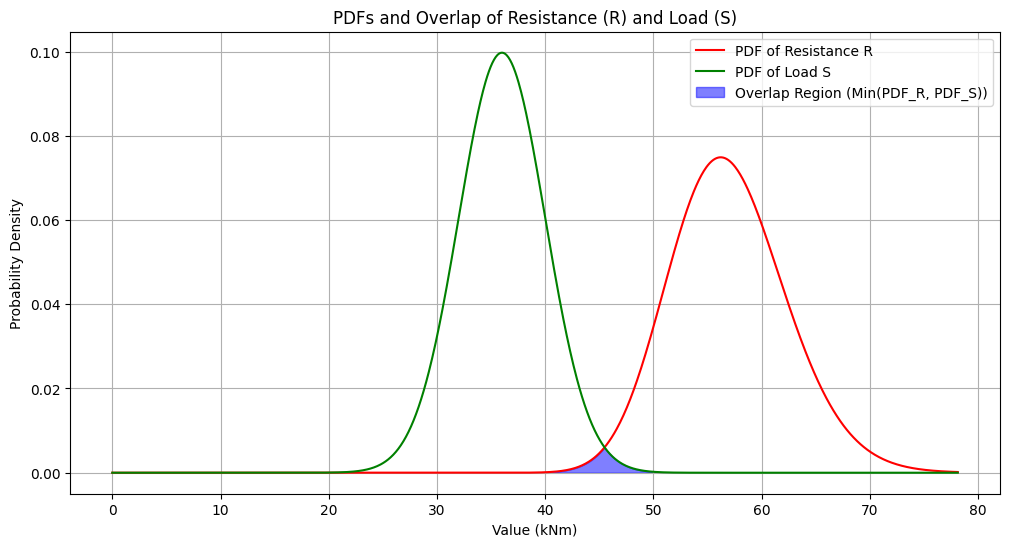

In [29]:
# Generate x values
x = np.linspace(0, max(lognormal_mean + 4 * lognormal_std_dev, normal_mean + 4 * normal_std_dev), 1000)

# Compute PDFs for R and S
pdf_R = lognorm.pdf(x, sigma, scale=np.exp(mu))
pdf_S = norm.pdf(x, loc=normal_mean, scale=normal_std_dev)

# Compute the overlap region as the minimum of the two PDFs
overlap = np.minimum(pdf_R, pdf_S)

# Plot the distributions and the overlap region
plt.figure(figsize=(12, 6))
plt.plot(x, pdf_R, label='PDF of Resistance R', color='red')
plt.plot(x, pdf_S, label='PDF of Load S', color='green')
plt.fill_between(x, overlap, color='blue', alpha=0.5, label='Overlap Region (Min(PDF_R, PDF_S))')
plt.title("PDFs and Overlap of Resistance (R) and Load (S)")
plt.xlabel("Value (kNm)")
plt.ylabel("Probability Density")
plt.legend()
plt.grid()
plt.show()

The probability of failure derives to: $\int F_R(x) * f_S(x) dx$, where $F_R(x)$ is the CDF of the resistance and $f_S(x)$ the PDF of the load effect. The integral is denoted as the "Weighted likelihood that  $R \leq S$".

<>:26: SyntaxWarning: invalid escape sequence '\l'
<>:26: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_2810/2403232099.py:26: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel("Weighted likelihood that  $R \leq S$")


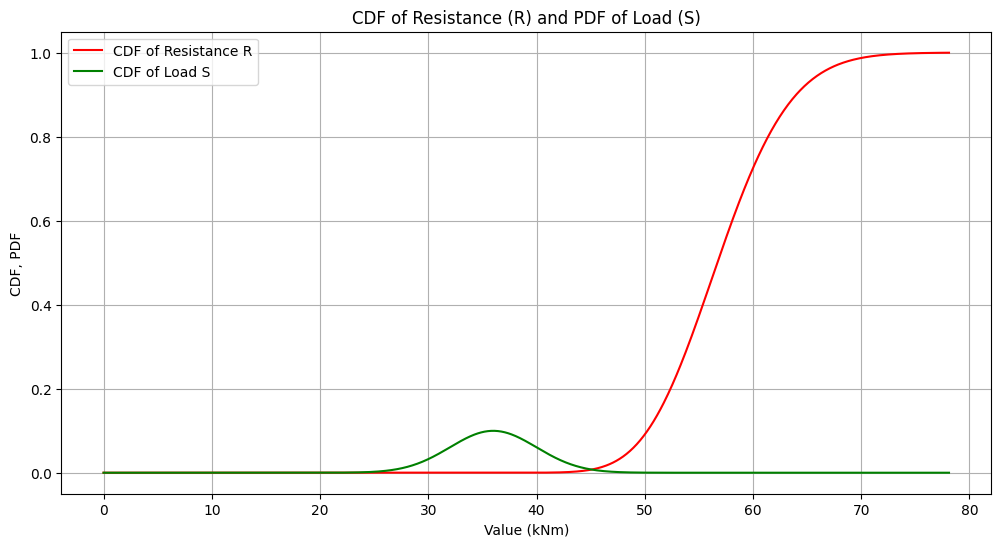

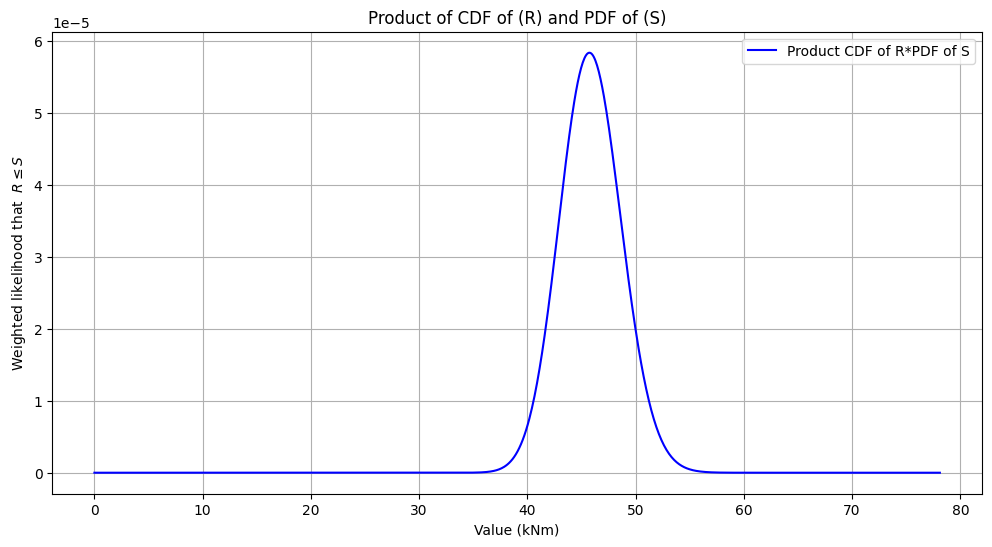

Probability of Failure (P(R ≤ S)): 0.0004


In [32]:
# Compute the probability of failure using numerical integration
failure_probability, _ = quad(lambda x: F_R(x) * f_S(x), 0, np.inf)

# Plot the CDFs
x = np.linspace(0, max(lognormal_mean + 4 * lognormal_std_dev, normal_mean + 4 * normal_std_dev), 1000)
plt.figure(figsize=(12, 6))
plt.plot(x, lognorm.cdf(x, sigma, scale=np.exp(mu)), label='CDF of Resistance R', color='red')
plt.plot(x, norm.pdf(x, loc=normal_mean, scale=normal_std_dev), label='CDF of Load S', color='green')

# Title and labels
plt.title("CDF of Resistance (R) and PDF of Load (S)")
plt.xlabel("Value (kNm)")
plt.ylabel("CDF, PDF")
plt.legend()
plt.grid()
plt.show()

# Plot the product of CDF_R * PDF_S >>> Wighted likelihood that  R ≤ S
x = np.linspace(0, max(lognormal_mean + 4 * lognormal_std_dev, normal_mean + 4 * normal_std_dev), 1000)
plt.figure(figsize=(12, 6))
plt.plot(x, lognorm.cdf(x, sigma, scale=np.exp(mu))*norm.pdf(x, loc=normal_mean, scale=normal_std_dev), label='Product CDF of R*PDF of S', color='blue')

# Title and labels
plt.title("Product of CDF of (R) and PDF of (S)")
plt.xlabel("Value (kNm)")
plt.ylabel("Weighted likelihood that  $R \leq S$")
plt.legend()
plt.grid()
plt.show()

#Determin the probability of failure
failure_probability, _ = quad(lambda x: F_R(x) * f_S(x), 0, 100)  # Use realistic upper bound
print(f"Probability of Failure (P(R ≤ S)): {failure_probability:.4f}")

# Solution as a Monte-Carlo Simulation 

Another way of solving the expected probabiliy of failure is a numerical approach, where a large set of random numbers are generated (following the original distributions). The probabiltity of failure simply calculates as $N_f/N$, where N_f is the number of sample pairs with $R <S$ (failure) and $N$ the number of sample pairs.

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm, norm

# Parameters for the lognormal distribution (R: Resistance)
Wel = 214  # cm^3
lognormal_mean = 26.5 * Wel / 100  # kNm
lognormal_std_dev = 2.5 * Wel / 100  # kNm
mu = np.log(lognormal_mean)  # Natural logarithm of the mean
sigma = lognormal_std_dev / lognormal_mean  # Approximation for the standard deviation as a fraction of the mean

# Parameters for the normal distribution (S: Load)
L = 200  # cm
normal_mean = 18 * L / 100  # kNm
normal_std_dev = 2 * L / 100  # kNm

# Generate random samples for R and S
np.random.seed(42)  # For reproducibility
=10000
R_samples = lognorm.rvs(sigma, scale=np.exp(mu), size=10000)
S_samples = norm.rvs(loc=normal_mean, scale=normal_std_dev, size=10000)

# Create 2D histogram
hist, xedges, yedges = np.histogram2d(R_samples, S_samples, bins=30, density=True)

# Generate bin centers for the plot
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
xcenters, ycenters = np.meshgrid(xcenters, ycenters)

# Create a 3D histogram plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the bars
ax.bar3d(xcenters.ravel(), ycenters.ravel(), np.zeros_like(hist.ravel()), 
         xedges[1] - xedges[0], yedges[1] - yedges[0], hist.ravel(), shade=True, cmap="viridis")

# Add labels and title
ax.set_title("3D Histogram of R and S")
ax.set_xlabel("Resistance (R) [kNm]")
ax.set_ylabel("Load (S) [kNm]")
ax.set_zlabel("Density")
plt.show()

#Determin the probability of failure
failure_probability=(R_samples<S_samples)/nsamples
print(f"Probability of Failure (P(R ≤ S)): {failure_probability:.4f}")

SyntaxError: invalid syntax (3413174574.py, line 19)

These are just to generate some plots...

/tmp/ipykernel_2810/1377556020.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


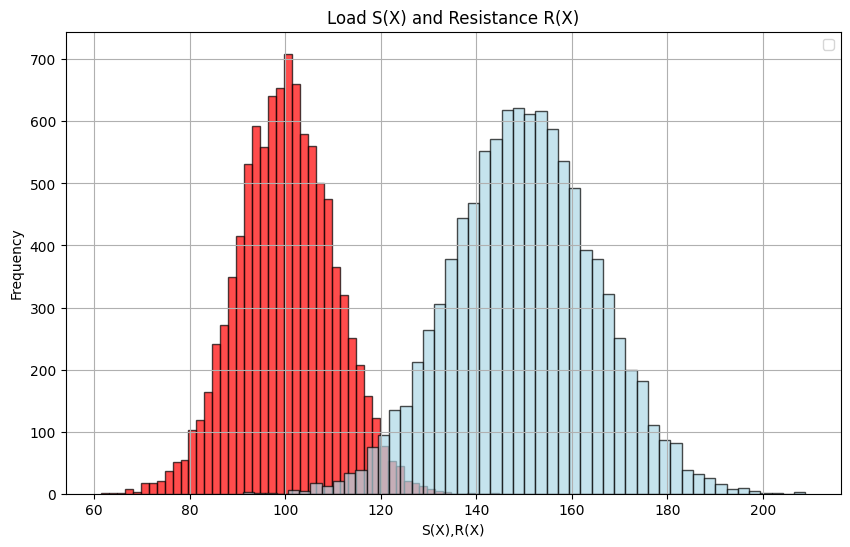

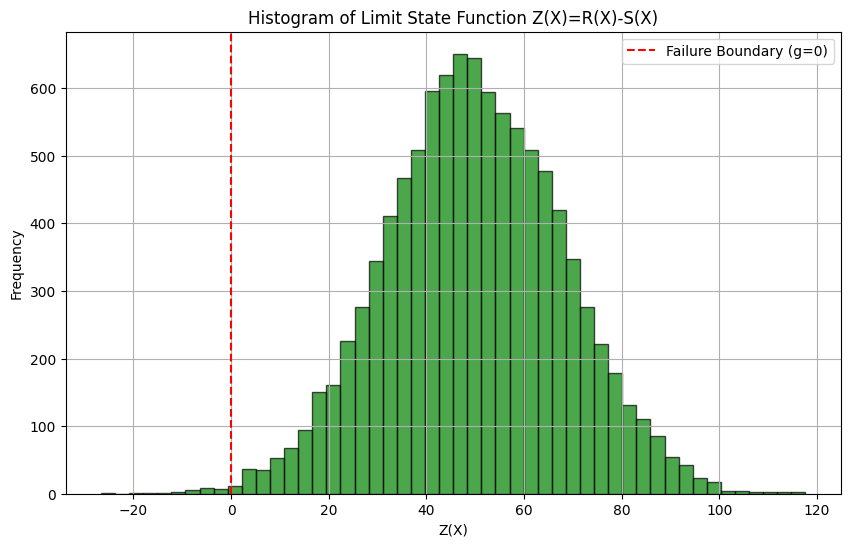

Probability of Failure: 1.0000


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
mean_resistance = 150  # Mean resistance (e.g., kN)
std_resistance = 15    # Standard deviation of resistance

mean_load = 100        # Mean applied load (e.g., kN)
std_load = 10          # Standard deviation of applied load

# Define the limit state function
def limit_state_function(R, S):
    """
    Linear limit state function g(X) = R - S
    R: Resistance (random variable)
    S: Load (random variable)
    """
    return R - S

# Generate random samples for resistance and load
np.random.seed(42)  # For reproducibility
num_samples = 10000
resistance_samples = np.random.normal(mean_resistance, std_resistance, num_samples)
load_samples = np.random.normal(mean_load, std_load, num_samples)

# Evaluate the limit state function for each sample
Z_samples = limit_state_function(resistance_samples, load_samples)

# Calculate probability of failure
probability_of_failure = len(Z_samples < 0)/len(Z_samples)  # Fraction of samples where g(X) < 0

# Plot histograms of R(X), S(X)
plt.figure(figsize=(10, 6))
plt.hist(load_samples, bins=50, color='red', edgecolor='black', alpha=0.7)
plt.hist(resistance_samples, bins=50, color='lightblue', edgecolor='black', alpha=0.7)
plt.title("Load S(X) and Resistance R(X)")
plt.xlabel("S(X),R(X)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.savefig('LimitStateMonteCarlo-RS.png', format='png', dpi=200)
plt.show()

# Plot histogram of g(X)
plt.figure(figsize=(10, 6))
plt.hist(Z_samples, bins=50, color='green', edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label="Failure Boundary (g=0)")
plt.title("Histogram of Limit State Function Z(X)=R(X)-S(X)")
plt.xlabel("Z(X)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.savefig('LimitStateMonteCarlo.png', format='png', dpi=200)
plt.show()

# Print probability of failure
print(f"Probability of Failure: {probability_of_failure:.4f}")

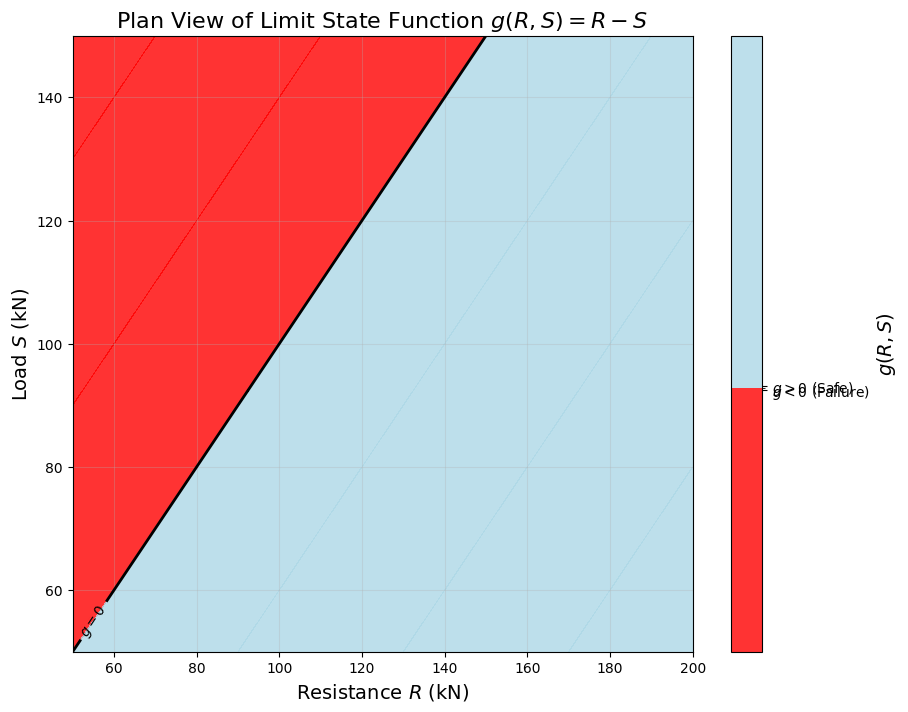

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# Parameters for resistance (R) and load (S)
R_min, R_max = 50, 200  # Range of resistance values
S_min, S_max = 50, 150  # Range of load values

# Create a grid of R and S values
R = np.linspace(R_min, R_max, 100)
S = np.linspace(S_min, S_max, 100)
R_grid, S_grid = np.meshgrid(R, S)

# Compute the limit state function g(R, S) = R - S
g_grid = R_grid - S_grid

# Define custom colormap for two colors
cmap = ListedColormap(["red", "lightblue"])  # Red for g < 0, Green for g > 0
bounds = [-np.inf, 0, np.inf]  # Define boundaries for g
norm = BoundaryNorm(bounds, cmap.N)  # Normalize values to the two colors

# Create a contour plot
plt.figure(figsize=(10, 8))
contour = plt.contourf(R_grid, S_grid, g_grid, cmap=cmap, norm=norm, alpha=0.8)
contour_lines = plt.contour(R_grid, S_grid, g_grid, levels=[0], colors="black", linestyles="solid", linewidths=2)

# Add labels and color bar
plt.title("Plan View of Limit State Function $g(R, S) = R - S$", fontsize=16)
plt.xlabel("Resistance $R$ (kN)", fontsize=14)
plt.ylabel("Load $S$ (kN)", fontsize=14)
cbar = plt.colorbar(contour, ticks=[-1, 1])  # Custom ticks for the two regions
cbar.ax.set_yticklabels(["$g < 0$ (Failure)", "$g > 0$ (Safe)"])  # Custom labels
cbar.set_label("$g(R, S)$", fontsize=14)

# Highlight the failure boundary
plt.clabel(contour_lines, inline=True, fontsize=10, fmt="$g=0$")

# Show the plot
plt.grid(alpha=0.3)
plt.show()


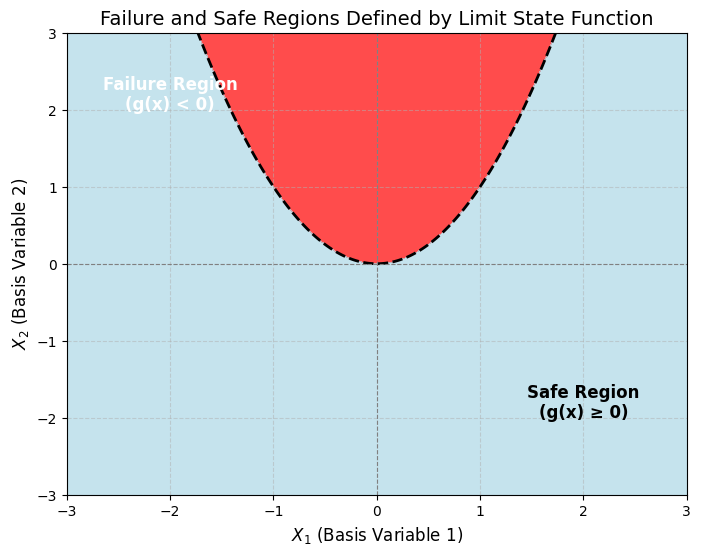

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define the limit state function g(x1, x2)
def g(x1, x2):
    return x1**2 - x2

# Create a grid of x1 and x2 values
x1 = np.linspace(-3, 3, 500)
x2 = np.linspace(-3, 3, 500)
X1, X2 = np.meshgrid(x1, x2)

# Evaluate g(x1, x2) on the grid
G = g(X1, X2)

# Plot the failure and safe regions
plt.figure(figsize=(8, 6))
plt.contourf(X1, X2, G, levels=[-np.inf, 0, np.inf], colors=["red", "lightblue"], alpha=0.7)
plt.contour(X1, X2, G, levels=[0], colors="black", linewidths=2, linestyles="--")
#plt.colorbar(label="g(x1, x2)")

# Annotate regions
plt.text(-2, 2, "Failure Region\n(g(x) < 0)", color="white", fontsize=12, weight="bold", ha="center")
plt.text(2, -2, "Safe Region\n(g(x) ≥ 0)", color="black", fontsize=12, weight="bold", ha="center")

# Add labels and title
plt.xlabel("$X_1$ (Basis Variable 1)", fontsize=12)
plt.ylabel("$X_2$ (Basis Variable 2)", fontsize=12)
plt.title("Failure and Safe Regions Defined by Limit State Function", fontsize=14)
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
plt.axvline(0, color='gray', linewidth=0.8, linestyle='--')

# Show the plot
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('FailureSafeRegions.png', format='png', dpi=200)
plt.show()